In [1]:
import json
import glob
import time
import pickle
import jsonlines
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter, defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

colors = ['#0072B2', '#56B4E9', '#E69F00', '#CC79A7', '#009E73', '#F0E442']

## Load Synsets

In [2]:
# ImageNet 1k concepts manually mapped onto Wikipedia pages
synsets_df = pd.read_csv("synset_to_en-wiki.csv", "\t")
print(synsets_df.shape)
synsets_df.head()

(1000, 2)


,concept,en wiki
0,English setter,https://en.wikipedia.org/wiki/English_Setter
1,"grey whale, gray whale, devilfish, Eschrichtiu...",https://en.wikipedia.org/wiki/Gray_whale
2,Egyptian cat,https://en.wikipedia.org/wiki/Egyptian_Mau
3,"Staffordshire bullterrier, Staffordshire bull ...",https://en.wikipedia.org/wiki/Staffordshire_Bu...
4,miniature poodle,https://en.wikipedia.org/wiki/Poodle


In [3]:
name2wiki = {e['concept']: e['en wiki'] for e in synsets_df.to_dict('records')}

In [4]:
# NLVR2 synsets
nlvr_synsets = set()
with jsonlines.open('../data/en/annotations/train.jsonl') as reader:
    for obj in reader:
        nlvr_synsets.add(obj['synset'])
len(nlvr_synsets)

nlvr_wikis = defaultdict(list)
s_synsets = set(synsets_df['concept'])
for syn in nlvr_synsets:
    for s in s_synsets:
        if syn in {e.strip() for e in s.split(',')}:
            nlvr_wikis[syn].append(name2wiki[s])
            
nlvr_synsets_df = pd.DataFrame.from_dict(nlvr_wikis, orient='index')
nlvr_synsets_df = nlvr_synsets_df.reset_index().rename(columns={'index': 'concept', 0: 'en wiki'})
nlvr_synsets_df.head()

,concept,en wiki
0,cheetah,https://en.wikipedia.org/wiki/Cheetah
1,flute,https://en.wikipedia.org/wiki/Flute
2,goose,https://en.wikipedia.org/wiki/Goose
3,miniature schnauzer,https://en.wikipedia.org/wiki/Miniature_Schnauzer
4,knee pad,https://en.wikipedia.org/wiki/Knee_pad


In [5]:
# MaRVL synsets

# id
with jsonlines.open("../data/id/annotations/marvl-id.jsonl") as reader:
    id_concepts = set([item['concept'].split("-")[-1].strip() for item in reader])
print('id', len(id_concepts))
    
# sw
with jsonlines.open("../data/sw/annotations/marvl-sw.jsonl") as reader:
    sw_concepts = set([item['concept'].split("-")[-1].strip() for item in reader])
print('sw', len(sw_concepts))

# ta
with jsonlines.open("../data/ta/annotations/marvl-ta.jsonl") as reader:
    ta_concepts = set([item['concept'].split("-")[-1].strip() for item in reader])
print('ta', len(ta_concepts))
    
# tr
with jsonlines.open("../data/tr/annotations/marvl-tr.jsonl") as reader:
    tr_concepts = set([item['concept'].split("-")[-1].strip() for item in reader])
print('tr', len(tr_concepts))

# zh
with jsonlines.open("../data/zh/annotations/marvl-zh.jsonl") as reader:
    zh_concepts = set([item['concept'].split("-")[-1].strip() for item in reader])
print('zh', len(zh_concepts))

# Synsets DataFrame
marvl_synsets_df = pd.DataFrame()
marvl_synsets_df['concept'] = list(id_concepts) + list(sw_concepts) + list(ta_concepts) + list(tr_concepts) + list(zh_concepts)
marvl_synsets_df['lang'] = ['id']*len(id_concepts) + ['sw']*len(sw_concepts) + ['ta']*len(ta_concepts) + ['tr']*len(tr_concepts) + ['zh']*len(zh_concepts)
marvl_synsets_df.head()


id 95
sw 78
ta 83
tr 79
zh 94


,concept,lang
0,Rambutan,id
1,Renang_(olahraga),id
2,Agama_Buddha,id
3,Patung,id
4,Bajak,id


## Get cross-lingual stats

In [ ]:
import requests

def get_json(url):
    u = requests.get(url=url)
    return u.json()

In [ ]:
# ImageNet
synset2langs = defaultdict(list)
synset2nlangs = dict()
for ix, row in tqdm(synsets_df.iterrows(), total=len(synsets_df)):
    s, en_url = row
    api_url = f"https://en.wikipedia.org/w/api.php?action=query&titles={en_url.split('/')[-1]}&prop=langlinks&lllimit=500&format=json"
    data = get_json(api_url)
    try:
        result = list(data["query"]["pages"].values())[0]["langlinks"]

        count = len(result)
        synset2nlangs[s] = count

        for res in result:
            synset2langs[s].append(res['lang'])
    except:
        print(s)
        synset2nlangs[s] = 0
        synset2langs[s] = []

with open("synset2langs.pkl", "wb") as f:
    pickle.dump(synset2langs, f)
    
with open("synset2nlangs.pkl", "wb") as f:
    pickle.dump(synset2nlangs, f)

In [ ]:
# NLVR2
nlvr_synset2langs = defaultdict(list)
nlvr_synset2nlangs = dict()
for ix, row in tqdm(nlvr_synsets_df.iterrows(), total=len(nlvr_synsets_df)):
    s, en_url = row
    api_url = f"https://en.wikipedia.org/w/api.php?action=query&titles={en_url.split('/')[-1]}&prop=langlinks&lllimit=500&format=json"
    data = get_json(api_url)
    try:
        result = list(data["query"]["pages"].values())[0]["langlinks"]

        count = len(result)
        nlvr_synset2nlangs[s] = count

        for res in result:
            nlvr_synset2langs[s].append(res['lang'])
    except:
        print(s)
        nlvr_synset2nlangs[s] = 0
        nlvr_synset2langs[s] = []

with open("nlvr_synset2langs.pkl", "wb") as f:
    pickle.dump(nlvr_synset2langs, f)
    
with open("nlvr_synset2nlangs.pkl", "wb") as f:
    pickle.dump(nlvr_synset2nlangs, f)

In [ ]:
# MaRVL
marvl_synset2langs = defaultdict(list)
marvl_synset2nlangs = dict()
for ix, row in tqdm(marvl_synsets_df.iterrows(), total=len(marvl_synsets_df)):
    s, l = row
    api_url = f"https://{l}.wikipedia.org/w/api.php?action=query&titles={s}&prop=langlinks&lllimit=500&format=json"
    data = get_json(api_url)
    try:
        result = list(data["query"]["pages"].values())[0]["langlinks"]

        count = len(result)
        marvl_synset2nlangs[s] = count + 1

        marvl_synset2langs[s].append(l)
        for res in result:
            marvl_synset2langs[s].append(res['lang'])
    except:
        time.sleep(1)
        try:
            result = list(data["query"]["pages"].values())[0]["langlinks"]

            count = len(result)
            marvl_synset2nlangs[s] = count + 1

            marvl_synset2langs[s].append(l)
            for res in result:
                marvl_synset2langs[s].append(res['lang'])
        except:
            print(s)
            marvl_synset2nlangs[s] = 0
            marvl_synset2langs[s] = []

with open("marvl_synset2langs.pkl", "wb") as f:
    pickle.dump(marvl_synset2langs, f)
    
with open("marvl_synset2nlangs.pkl", "wb") as f:
    pickle.dump(marvl_synset2nlangs, f)

## Load cross-lingual stats

In [6]:
# Load ImageNet cross-lingual stats
inet_synset2langs = pickle.load(open("synset2langs.pkl", "rb"))
inet_synset2nlangs = pickle.load(open("synset2nlangs.pkl", "rb"))
print("ImageNet:", len(inet_synset2nlangs))

# Load NLVR2 cross-lingual stats
nlvr_synset2langs = pickle.load(open("nlvr_synset2langs.pkl", "rb"))
nlvr_synset2nlangs = pickle.load(open("nlvr_synset2nlangs.pkl", "rb"))
print("NLVR2:", len(nlvr_synset2nlangs))

# Load MaRVL cross-lingual stats
marvl_synset2langs = pickle.load(open("marvl_synset2langs.pkl", "rb"))
marvl_synset2nlangs = pickle.load(open("marvl_synset2nlangs.pkl", "rb"))
print("MaRVL:", len(marvl_synset2nlangs))

ImageNet: 999
NLVR2: 124
MaRVL: 445


In [7]:
# Add English language
for s in inet_synset2langs:
    inet_synset2langs[s] += ['en']
    inet_synset2nlangs[s] += 1
    
for s in nlvr_synset2langs:
    nlvr_synset2langs[s] += ['en']
    nlvr_synset2nlangs[s] += 1
    
for s in marvl_synset2langs:
    marvl_synset2langs[s] += ['en']
    marvl_synset2nlangs[s] += 1

In [8]:
# Get list of languages spanned by each dataset
inet_langs = set()
for s, lst in inet_synset2langs.items():
    for l in lst:
        inet_langs.add(l)
print("ImageNet:", len(inet_langs))

nlvr_langs = set()
for s, lst in nlvr_synset2langs.items():
    for l in lst:
        nlvr_langs.add(l)
print("NLVR2:", len(nlvr_langs))

marvl_langs = set()
for s, lst in marvl_synset2langs.items():
    for l in lst:
        marvl_langs.add(l)
print("MaRVL:", len(marvl_langs))

ImageNet: 305
NLVR2: 273
MaRVL: 311


In [9]:
# Map each language to its ISO codes
from iso639 import Lang  # pip install iso639-lang

inet_lang2codes = dict()
for l in sorted(inet_langs):
    try:
        inet_lang2codes[l] = Lang(l)
    except:
        pass
print("ImageNet:", len(inet_lang2codes))

nlvr_lang2codes = dict()
for l in sorted(nlvr_langs):
    try:
        nlvr_lang2codes[l] = Lang(l)
    except:
        pass
print("NLVR2:", len(nlvr_lang2codes))

marvl_lang2codes = dict()
for l in sorted(marvl_langs):
    try:
        marvl_lang2codes[l] = Lang(l)
    except:
        pass
print("MaRVL:", len(marvl_lang2codes))

ImageNet: 292
NLVR2: 262
MaRVL: 298


In [10]:
# Load WALS features
langs_df = pd.read_csv("languages.csv")
langs_df.head()

,ID,Name,Macroarea,Latitude,Longitude,Glottocode,ISO639P3code,Family,Subfamily,Genus,GenusIcon,ISO_codes,Samples_100,Samples_200,Country_ID,Source
0,aab,Arapesh (Abu),NaN,-3.450000,142.950000,NaN,NaN,Torricelli,NaN,Kombio-Arapesh,c0000dd,NaN,False,False,PG,Nekitel-1985
1,aar,Aari,Africa,6.000000,36.583333,aari1239,aiw,Afro-Asiatic,Omotic,South Omotic,ccccccc,aiw,False,False,ET,Hayward-1990a
2,aba,Abau,Papunesia,-4.000000,141.250000,abau1245,aau,Sepik,NaN,Upper Sepik,ddd0000,aau,False,False,PG,Bailey-1975
3,abb,Arabic (Chadian),Africa,13.833333,20.833333,chad1249,shu,Afro-Asiatic,NaN,Semitic,cdd0000,shu,False,False,TD,Abu-Absi-1995
4,abd,Abidji,Africa,5.666667,-4.583333,abid1235,abi,Niger-Congo,NaN,Kwa,d009900,abi,False,False,CI,NaN


## Analysis per Language

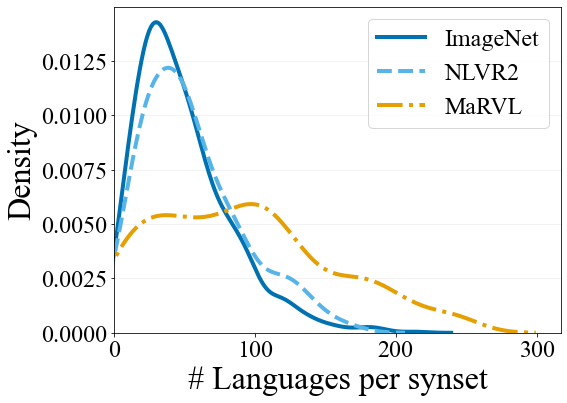

In [11]:
f, ax = plt.subplots(figsize=(8,6))

x, y = np.unique(sorted([v for v in inet_synset2nlangs.values() if v > 0]), return_counts=True)
sns.kdeplot(x=[v for v in inet_synset2nlangs.values() if v > 0], color=colors[0], lw=4, ls='-', label='ImageNet', ax=ax)

x, y = np.unique(sorted([v for v in nlvr_synset2nlangs.values() if v > 0]), return_counts=True)
sns.kdeplot(x=[v for v in nlvr_synset2nlangs.values() if v > 0], color=colors[1], lw=4, ls='--', label='NLVR2', ax=ax)

x, y = np.unique(sorted([v for v in marvl_synset2nlangs.values() if v > 0]), return_counts=True)
sns.kdeplot(x=[v for v in marvl_synset2nlangs.values() if v > 0],  color=colors[2], lw=4, ls='-.', label='MaRVL', ax=ax)

ax.set_xlabel("# Languages per synset", fontsize=32)
ax.set_ylabel("Density", fontsize=32)
ax.set_xlim(0)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.grid(alpha=0.2, axis='y')
ax.legend(fontsize=24)

f.savefig("synsets_languages.pdf", bbox_inches="tight")

## Analisys per Macroarea

In [12]:
# Map language names onto macroarea
lang2area = {r['ISO639P3code']: r['Macroarea'] for _, r in langs_df.iterrows()}
lang2area['ita']

'Eurasia'

In [13]:
# Map language ids onto macroarea
id2area = {r['ID']: r['Macroarea'] for _, r in langs_df.iterrows()}
id2area['ita']

'Eurasia'

In [14]:
# number of ImageNet synsets per macroarea
inet_area2synsets = defaultdict(list)
missed_langs = set()
for s, lst in inet_synset2langs.items():
    synset_areas = set()  # counts 1 even if in many languages
    for l in lst:
        try:
            a = lang2area[inet_lang2codes[l].pt3]
            synset_areas.add(a)
        except:
            try:
                a = id2area[inet_lang2codes[l].pt3]
                synset_areas.add(a)
            except:
                missed_langs.add(l)
    for a in synset_areas:
        inet_area2synsets[a].append(s)
print("ImageNet:", len(missed_langs))

# number of NLVR2 synsets per macroarea
nlvr_area2synsets = defaultdict(list)
missed_langs = set()
for s, lst in nlvr_synset2langs.items():
    synset_areas = set()  # counts 1 even if in many languages
    for l in lst:
        try:
            a = lang2area[nlvr_lang2codes[l].pt3]
            synset_areas.add(a)
        except:
            try:
                a = id2area[nlvr_lang2codes[l].pt3]
                synset_areas.add(a)
            except:
                missed_langs.add(l)
    for a in synset_areas:
        nlvr_area2synsets[a].append(s)
print("NLVR2:", len(missed_langs))

# number of MaRVL synsets per macroarea
marvl_area2synsets = defaultdict(list)
missed_langs = set()
for s, lst in marvl_synset2langs.items():
    synset_areas = set()  # counts 1 even if in many languages
    for l in lst:
        try:
            a = lang2area[marvl_lang2codes[l].pt3]
            synset_areas.add(a)
        except:
            try:
                a = id2area[nlvr_lang2codes[l].pt3]
                synset_areas.add(a)
            except:
                missed_langs.add(l)
    for a in synset_areas:
        marvl_area2synsets[a].append(s)
print("MaRVL:", len(missed_langs))

ImageNet: 59
NLVR2: 51
MaRVL: 67


<ipython-input-15-c946bed78da9>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + names, fontsize=28, rotation=0);


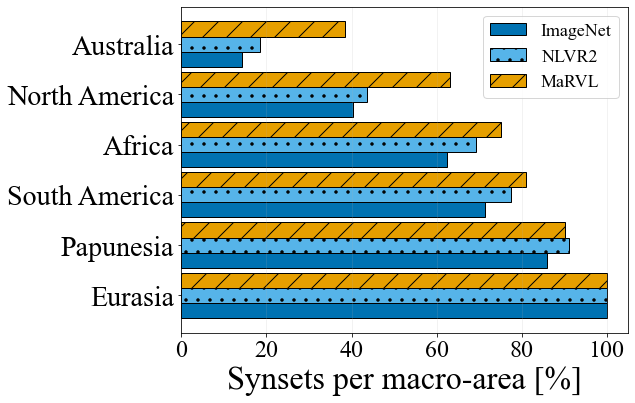

In [15]:
f, ax = plt.subplots(figsize=(8,6))
w = 0.3

names = ['Eurasia', 'Papunesia', 'South America', 'Africa', 'North America', 'Australia']
xs = np.array(range(len(names)))
ax.barh(xs - w, [100*len(inet_area2synsets[k])/len(inet_synset2langs) for k in names], height=w, color=colors[0], ec='k', label='ImageNet')
ax.barh(xs, [100*len(nlvr_area2synsets[k])/len(nlvr_synset2langs) for k in names], height=w, color=colors[1], ec='k', hatch='.', label='NLVR2')
ax.barh(xs + w, [100*len(marvl_area2synsets[k])/len(marvl_synset2langs) for k in names], height=w, color=colors[2], ec='k', hatch='/', label='MaRVL')

ax.set_xlabel("Synsets per macro-area [%]", fontsize=32)
ax.tick_params(axis='x', which='major', labelsize=24)
ax.set_yticklabels([''] + names, fontsize=28, rotation=0);
ax.grid(alpha=0.2, axis='x')
ax.legend(fontsize=18)

f.savefig("synsets_macroareas.pdf", bbox_inches="tight")

## Analysis per Family

In [16]:
# Map language names onto families
lang2fam = {r['ISO639P3code']: r['Family'] for _, r in langs_df.iterrows()}
lang2fam['ita']

'Indo-European'

In [17]:
# Map language ids onto families
id2fam = {r['ID']: r['Family'] for _, r in langs_df.iterrows()}
id2fam['ita']

'Indo-European'

In [18]:
# number of ImageNet synsets per family
inet_fam2synsets = defaultdict(list)
for s, lst in inet_synset2langs.items():
    synset_fams = set()  # counts 1 even if in many languages
    for l in lst:
        try:
            a = lang2fam[inet_lang2codes[l].pt3]
            if type(a) == str:
                synset_fams.add(a)
        except:
            try:
                a = id2fam[inet_lang2codes[l].pt3]
                if type(a) == str:
                    synset_fams.add(a)
            except:
                pass
    for a in synset_fams:
        inet_fam2synsets[a].append(s)
print("ImageNet:", len(inet_fam2synsets))
        
# number of NLVR2 synsets per family
nlvr_fam2synsets = defaultdict(list)
for s, lst in nlvr_synset2langs.items():
    synset_fams = set()  # counts 1 even if in many languages
    for l in lst:
        try:
            a = lang2fam[nlvr_lang2codes[l].pt3]
            if type(a) == str:
                synset_fams.add(a)
        except:
            try:
                a = id2fam[nlvr_lang2codes[l].pt3]
                if type(a) == str:
                    synset_fams.add(a)
            except:
                pass
    for a in synset_fams:
        nlvr_fam2synsets[a].append(s)
print("NLVR2:", len(nlvr_fam2synsets))
        
# number of MaRVL synsets per family
marvl_fam2synsets = defaultdict(list)
for s, lst in marvl_synset2langs.items():
    synset_fams = set()  # counts 1 even if in many languages
    for l in lst:
        try:
            a = lang2fam[marvl_lang2codes[l].pt3]
            if type(a) == str:
                synset_fams.add(a)
        except:
            try:
                a = id2fam[marvl_lang2codes[l].pt3]
                if type(a) == str:
                    synset_fams.add(a)
            except:
                pass
    for a in synset_fams:
        marvl_fam2synsets[a].append(s)
print("MaRVL:", len(marvl_fam2synsets))

ImageNet: 35
NLVR2: 32
MaRVL: 35


<ipython-input-19-2496d7eebf66>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 20, 40, 60, 80, 100])


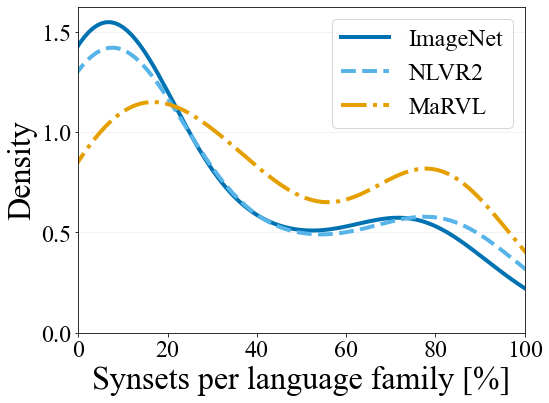

In [19]:
f, ax = plt.subplots(figsize=(8,6))

names = list(inet_fam2synsets.keys())

sns.kdeplot(x=[len(inet_fam2synsets[k])/len(inet_synset2langs) for k in names], color=colors[0], lw=4, ls='-', label='ImageNet', ax=ax)
sns.kdeplot(x=[len(nlvr_fam2synsets[k])/len(nlvr_synset2langs) for k in names], color=colors[1], lw=4, ls='--', label='NLVR2', ax=ax)
sns.kdeplot(x=[len(marvl_fam2synsets[k])/len(marvl_synset2langs) for k in names], color=colors[2], lw=4, ls='-.', label='MaRVL', ax=ax)

ax.set_xlabel("Synsets per language family [%]", fontsize=32)
ax.set_ylabel("Density", fontsize=32)
ax.set_xlim(0, 1)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_xticklabels([0, 20, 40, 60, 80, 100])
ax.grid(alpha=0.2, axis='y')
ax.legend(fontsize=24)

f.savefig("synsets_families.pdf", bbox_inches="tight")

In [ ]:
x